In [ ]:
import random
import os

import cv2
import imutils
from skimage.segmentation import clear_border
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# to sort counters from left to right
def get_contour_x_center_coordinate(contours):    
    if cv2.contourArea(contours) > 1:
        M = cv2.moments(contours)
    return (int(M['m10']/M['m00']))

In [85]:
def detect_digits(input_path, font, index1):
    index1 = index1
    input_image = cv2.imread(input_path)
    cv2.imwrite("./printed_digits/input_images/Check/input_image.jpg", input_image)
    input_image_sm = cv2.resize(input_image, (int(input_image.shape[1]/4), int(input_image.shape[0]/4)))
    #converting to gray scale
    input_gray=cv2.cvtColor(input_image_sm,cv2.COLOR_BGR2GRAY)

    #applying canny edge detection
    input_edged = cv2.Canny(input_gray, 50, 250)

    input_dil = cv2.dilate(input_edged, (9,9), iterations=2)
    cv2.imwrite(f"./printed_digits/dilated/{font}/dilated_image" + str(index1) + ".png", input_dil)
    
    #finding contours
    contours, _ = cv2.findContours(input_dil.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=cv2.contourArea)
    
    idx = 0
    count = len(sorted_contours)
    for c in sorted_contours:
        x,y,w,h = cv2.boundingRect(c) 
        idx+=1
        padY = 5
        padX = 9
        if x < padX:
            padX = x
        if y < padY:
            padY = y
        cropped_single_digit=input_image_sm[y-padY:y+h+padY,x-padX:x+w+padX]
        #cropping imagesabs
        if cropped_single_digit is not None:
            cv2.imwrite(f"./printed_digits/cropped/{font}/{font}_"+ str(index1) + "_" + str(idx) + ".png", cropped_single_digit)

    return input_image_sm, count

In [89]:
font = "Garamond"

# our folder path containing some images
folder_path = f'./printed_digits/input_images/{font}'

# loop on all files of the folder and build a list of files paths
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
images = [ x for x in images if ".DS_Store" not in x ]

index1 = 1

for i in images:
    input_image_sm, count = detect_digits(i, font, index1)
    index1 += 1

In [93]:
def prep_image(single_digit_path, font, index):
    image = cv2.imread(single_digit_path)
    image_gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret, image_bw = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV+ cv2.THRESH_OTSU)
    image_dil = cv2.dilate(image_bw, None, iterations=0)
        
    contours = cv2.findContours(image_dil.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # if no contours were found than this is an empty cell
    if len(contours) == 0:
        return None

    # otherwise, find the largest contour in the cell and create a
    # mask for the contour
    main_cell_contour = max(contours, key=cv2.contourArea)
    background = np.zeros(image_dil.shape, dtype="uint8")
    cv2.drawContours(background, [main_cell_contour], -1, 255, -1)

    # apply the mask to the thresholded cell
    image_masked = cv2.bitwise_and(image_dil, image_dil, mask=background)

    cv2.imwrite(f"./printed_digits/masked/{font}/" + str(index) + ".png", image_masked)

    # center crop
    w = 80
    h = 80
    
    #center = tuple(np.array(image_rot.shape[1::-1]) / 2)
    center = tuple(np.array(image_masked.shape[1::-1]) / 2)
    
    x = center[0] - w/2
    y = center[1] - h/2

    #image_crop = image_rot[int(y):int(y+h), int(x):int(x+w)]
    image_crop = image_masked[int(y-20):int(y+h+20), int(x-20):int(x+w+20)]
    
    # resize
    image_sm = cv2.resize(image_crop, (28, 28))

    cv2.imwrite(f"./printed_digits/train_images/{font}/{font}" + str(index) + ".png", image_sm)
     
    # reshape 
    image_reshaped = image_sm.reshape(1,28,28,1)
    
    test_image = (image_reshaped[...,::-1].astype(np.float32)) / 255.0 

In [94]:
font = "Calibri"

# our folder path containing some images
folder_path = f'./printed_digits/cropped/{font}' 

# loop on all files of the folder and build a list of files paths
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
images = [ x for x in images if ".DS_Store" not in x ]

index1 = 1

for i in images:
    prep_image(i, font, index1)
    index1 += 1

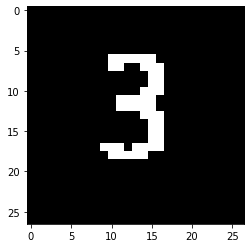

In [96]:
test_image = cv2.imread("./printed_digits/masked/Calibri/1.png")
plt.imshow(test_image)